In [1]:
'''Để cho đơn giản, máy chọn X, đối phương chọn O
X đi trước

tác tử (Agent): X
hành động (action A): thêm X vào bảng
tín hiệu phần thưởng (Reward signal R): R = {-1: thua, 1: thắng, 0: hòa, hoặc chưa kết thúc}
lợi tức (return G): kì vọng tổng các tín hiệu phần thưởng có discount
trạng thái (state S): 
    tùy thuộc vào đối phương, mỗi nước đi của X sản sinh ra nhiều trạng thái khác nhau
    thời điểm t -> t+1 là thời điểm thêm X vào bảng và tạo ra môi trường có X vừa thêm và O do đối thủ thêm vào, như vậy có thể coi t = số X có trong bảng
    Giả sử mỗi khi thêm X, xác suất xảy ra của mỗi trạng thái là như nhau
    cần mã hóa bảng trước khi cho vào hàm giá trị để giảm không gian lưu trữ
    Định nghĩa trạng thái kết thúc.

hàm giá trị (value function) v(s)
chiến lược: đi vào trạng thái có hàm giá trị lớn nhất

Các đối tượng:
- board
- Agent
'''


'Để cho đơn giản, máy chọn X, đối phương chọn O\nX đi trước\n\ntác tử (Agent): X\nhành động (action A): thêm X vào bảng\ntín hiệu phần thưởng (Reward signal R): R = {-1: thua, 1: thắng, 0: hòa, hoặc chưa kết thúc}\nlợi tức (return G): kì vọng tổng các tín hiệu phần thưởng có discount\ntrạng thái (state S): \n    tùy thuộc vào đối phương, mỗi nước đi của X sản sinh ra nhiều trạng thái khác nhau\n    thời điểm t -> t+1 là thời điểm thêm X vào bảng và tạo ra môi trường có X vừa thêm và O do đối thủ thêm vào, như vậy có thể coi t = số X có trong bảng\n    Giả sử mỗi khi thêm X, xác suất xảy ra của mỗi trạng thái là như nhau\n    cần mã hóa bảng trước khi cho vào hàm giá trị để giảm không gian lưu trữ\n    Định nghĩa trạng thái kết thúc.\n\nhàm giá trị (value function) v(s)\nchiến lược: đi vào trạng thái có hàm giá trị lớn nhất\n\nCác đối tượng:\n- board\n- Agent\n'

In [2]:
import numpy as np
import hashlib
import itertools

In [3]:
class Kernel:
    def __init__(self, is_setup_vp = True) -> None:
        self.H = 3
        self.W = 3

        self.value_function = {}

        if is_setup_vp:
            self.setup_vp(np.zeros((3,3)))
    
    def setup_vp(self, state) -> None:
        '''
        Thêm state hiện tại và các state phía sau
        B1: Thêm state hiện tại
            Nếu state hiện tại đã có, nên nó và những state sau nó cũng đã có -> dừng
        B2: Nếu state hiện tại là terminal -> dừng, nếu không, tiếp tục thêm các state phía sau
        '''
        
        # Thêm state hiện tại:
        if self.value_function.get(tuple(map(tuple, state))) is None:
            self.value_function[tuple(map(tuple, state))] = 0
        else:
            return None
        
        # kiểm tra terminal
        if self.is_terminal(state):
            return None
        
        nextActions = self.get_nextActions(state)
        for na in nextActions:
            nextStates = self.get_nextStates(na)
            if not nextStates:
                self.setup_vp(na)
            for ns in nextStates:
                self.setup_vp(ns)

    def reward_signal_kernel(self,kernel):#3x3
        # check rows
        for row in kernel:
            if row[0] == row[1] == row[2] and row[0] != 0:
                return row[0]
        # check columns:
        for col in range(3):
            if kernel[0][col] == kernel[1][col] == kernel[2][col] and kernel[0][col] != 0:
                return kernel[0][col]
        # check main diagonal
        if kernel[0][0] == kernel[1][1] == kernel[2][2] and kernel[0][0] != 0:
            return kernel[0][0]
        # check secondary diagonal
        if kernel[0][2] == kernel[1][1] == kernel[2][0] and kernel[0][2] != 0:
            return kernel[0][2]
        
        return 0
    
    def is_terminal(self, board):
        r = self.reward_signal_kernel(board)
        if r != 0:
            return True
        else:
            if 0 in board:
                return False
            else:
                return True
            
    def get_nextActions(self, state):
        # kiểm tra state đã kết thúc hoặc không thêm được X
        if self.is_terminal(state):
            return []
        idxs_empty = []
        
        # Tìm tất cả các ô trống (0)
        for i in range(self.H):
            for j in range(self.W):
                if state[i][j] == 0:
                    idxs_empty.append((i,j))

        if not idxs_empty:
            return []
        
        nextActions = [state]
        for i,j in idxs_empty:
            new_action = np.array([row[:] for row in state])
            new_action[i][j] = 1
            nextActions.append(new_action)

        return nextActions
    
    def get_nextStates(self, state):
        # kiểm tra state đã kết thúc hoặc không thêm được 0
        if self.is_terminal(state):
            return []
        idxs_empty = []
        
        # Tìm tất cả các ô trống (0)
        for i in range(self.H):
            for j in range(self.W):
                if state[i][j] == 0:
                    idxs_empty.append((i,j))

        if not idxs_empty:
            return []
        
        nextStates = [state]
        for i,j in idxs_empty:
            new_state = np.array([row[:] for row in state])
            new_state[i][j] = -1
            nextStates.append(new_state)

        return nextStates

In [4]:
class Player:
    def __init__(self) -> None:
        self.kernel = Kernel(is_setup_vp=False)
        pass
    def get_final_score(self, board):
        H, W = board.shape
        for i in range(H - 2):
            for j in range(W - 2):
                r = self.kernel.reward_signal_kernel(board[i:i+3, j:j+3])
                if r != 0:
                    return r
        return 0

    def check_terminal_board(self, board):
        H, W = board.shape
        for i in range(H - 2):
            for j in range(W - 2):
                r = self.kernel.reward_signal_kernel(board[i:i+3, j:j+3])
                if r != 0:
                    return True
        if 0 in board:#chưa kết thúc
            return False
        else:# hòa
            return True
        
    def predict(self, board):
        return board
    
    def predict_opponent(self, board):
        opt_board = board * -1
        return self.predict(opt_board) * -1
    
    def name(self):
        return None

In [5]:
import pickle
class Agent(Player):
    def __init__(self) -> None:
        super().__init__()
        self.theta = 10e-3
        self.gamma = 0.9
        self.kernel = Kernel()
    
    def train(self):
        try:
            with open('params-agent-tictactoe.pkl', 'rb') as pkl_file:
                self.kernel.value_function = pickle.load(pkl_file)
                return self.kernel.value_function
        except:
            pass

        epoch = 0

        while(True):
            delta = 0
            for t_s in self.kernel.value_function:
                s = np.array(t_s)
                if self.kernel.is_terminal(s):
                    self.kernel.value_function[tuple(map(tuple, s))] = self.kernel.reward_signal_kernel(s)
                else:
                    q = {}
                    actions = self.kernel.get_nextActions(s)
                    for a in actions:
                        if self.kernel.is_terminal(a):
                            q[tuple(map(tuple, a))] = self.kernel.reward_signal_kernel(a)
                            continue

                        next_states = self.kernel.get_nextStates(a)
                        q_a = []
                        for ns in next_states:
                            v_ns = self.kernel.value_function.get(tuple(map(tuple, ns)))
                            q_a.append(self.kernel.reward_signal_kernel(ns) + self.gamma*v_ns)
                        q_a = np.mean(q_a)
                        q[tuple(map(tuple, a))] = q_a

                    pi_s = max(q, key=q.get)

                    v = self.kernel.value_function.get(tuple(map(tuple, s)))
                    new_v = q[pi_s]

                    self.kernel.value_function[tuple(map(tuple, s))] = new_v

                    delta = max(delta, abs(v - new_v))
            epoch += 1
            print(f"epoch{epoch}: delta={delta}")
            if epoch % 1 == 0:
                a = np.array([[-1,-1,0],[0,0,0],[0,0,0]])
                print(self.kernel.value_function.get(tuple(map(tuple, a))))
            if delta < self.theta or epoch == 1000:
                break
        
        with open('params-agent-tictactoe.pkl', 'wb') as pkl_file:
            pickle.dump(self.kernel.value_function, pkl_file)
        return self.kernel.value_function

    def predict(self, board):
        state = board
        H, W = board.shape
        if self.check_terminal_board(board):
            return None
        # dịch kernel
        o_pi_kernel = None
        o_v_kernel = -10
        idx = None
        for i in range(H - 2):
            for j in range(W - 2):
                kernel = state[i:i+3, j:j+3]
                
                q = {}
                actions = self.kernel.get_nextActions(kernel)
                for a in actions:
                    if self.kernel.is_terminal(a):
                        q[tuple(map(tuple, a))] = self.kernel.reward_signal_kernel(a)
                        continue

                    next_states = self.kernel.get_nextStates(a)
                    q_a = []
                    for ns in next_states:
                        v_ns = self.kernel.value_function.get(tuple(map(tuple, ns)))
                        q_a.append(self.kernel.reward_signal_kernel(ns) + self.gamma*v_ns)
                    q_a = np.mean(q_a)
                    q[tuple(map(tuple, a))] = q_a

                pi_kernel = np.array(max(q, key=q.get))
                q_a_kernel = q.get(tuple(map(tuple, pi_kernel)))
                if q_a_kernel > o_v_kernel:
                    o_v_kernel = q_a_kernel
                    o_pi_kernel = pi_kernel
                    idx = (i,j)

        new_state = np.array([row[:] for row in state])
        i,j = idx
        new_state[i:i+3, j:j+3] = o_pi_kernel

        return new_state
    
    def name(self):
        return "agent"

In [6]:
import random
class RandomPlayer(Player):
    def __init__(self) -> None:
        super().__init__()
        pass
    def predict(self,board):
        H, W = board.shape
        if self.check_terminal_board(board):
            return None
        idxs_empty = []
        
        # Tìm tất cả các ô trống (0)
        for i in range(H):
            for j in range(W):
                if board[i][j] == 0:
                    idxs_empty.append((i,j))

        if not idxs_empty:
            return None
        
        random_idx = random.choice(idxs_empty)
        new_board = np.array([row[:] for row in board])

        i,j = random_idx
        new_board[i][j] = 1

        return new_board
    
    def name(self):
        return "random"
        

In [7]:
class HumanPlayer(Player):
    def __init__(self) -> None:
        super().__init__()
        pass
    def predict(self,board, i, j):
        new_board = np.array([row[:] for row in board])

        new_board[i][j] = 1

        return new_board
    def name(self):
        return "human"

In [8]:
class Game:
    def __init__(self) -> None:
        self.player = Player()
        self.agent = Agent()
        self.agent.train()
        self.random_player = RandomPlayer()

    def play(self, player1, player2, H, W):
        board = np.zeros((H, W))
        while(True):
            board = player1.predict(board)
            # print(board)
            if self.player.check_terminal_board(board):
                return self.player.get_final_score(board)
            board = player2.predict_opponent(board)
            # print(board)
            if self.player.check_terminal_board(board):
                return self.player.get_final_score(board)
            

In [9]:
game = Game()

agent-random-3x3: win, draw, lost - (995, 5, 0)
random-agent-3x3: win, draw, lost - (3, 61, 936)
agent-random-4x4: win, draw, lost - (995, 5, 0)
random-agent-4x4: win, draw, lost - (2, 67, 931)
agent-random-5x5: win, draw, lost - (994, 6, 0)
random-agent-5x5: win, draw, lost - (3, 66, 931)


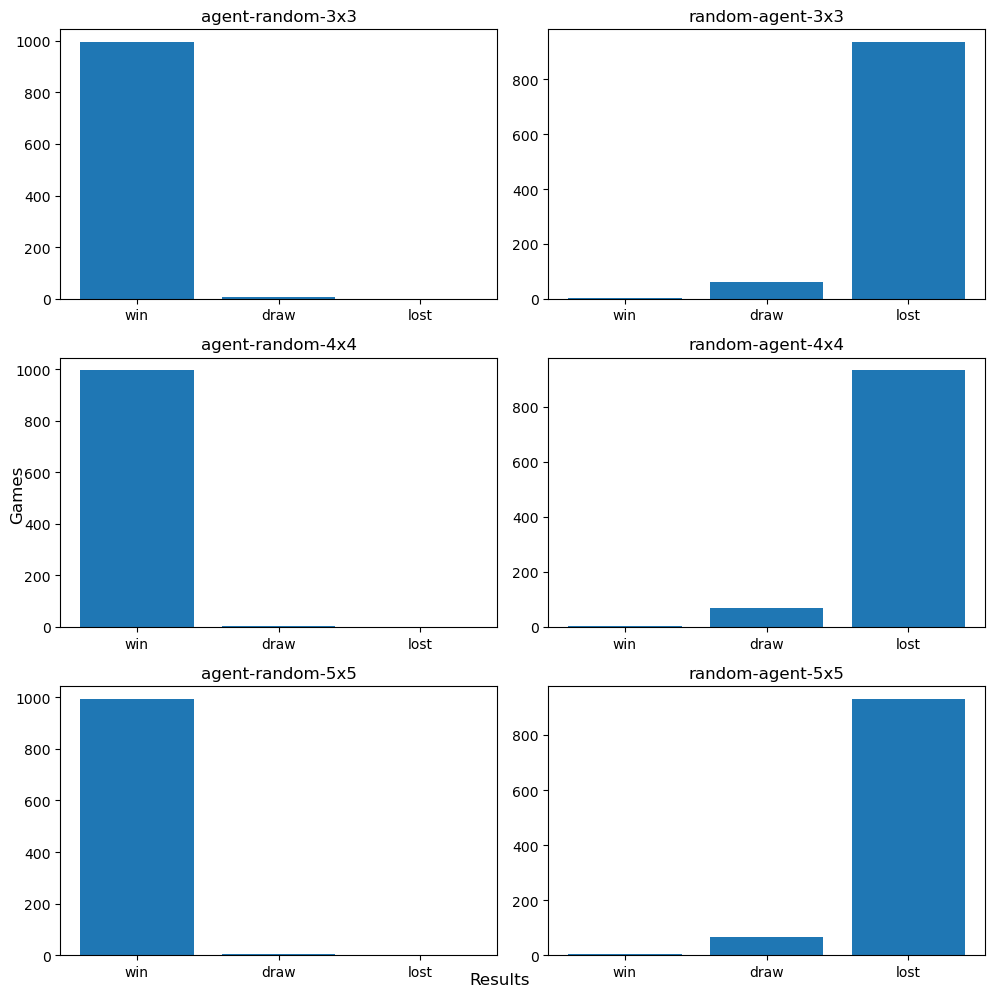

In [18]:
'''
agent-random-3x3
random-agent-3x3
agent-random-4x4
random-agent-4x4
agent-random-5x5
random-agent-5x5
'''
import matplotlib.pyplot as plt
j = 0
plt.figure(figsize=(10, 10))
for size in [3,4,5]:
    for pair_player in [(game.agent, game.random_player), (game.random_player, game.agent)]:
        player1, player2 = pair_player
        statistic = {'win':0, 'draw':0, 'lost':0}
        for i in range(1000):
            score = game.play(player1, player2, 3, 3)
            result = None
            if score == 1:
                statistic['win'] += 1
                result = "win"
            elif score == -1:
                statistic['lost'] += 1
                result = "lost"
            else:
                statistic['draw'] += 1
                result = "draw"
            # print(f"game {i+1}: {result}")
        print(f"{player1.name()}-{player2.name()}-{size}x{size}: win, draw, lost - {statistic['win'], statistic['draw'], statistic['lost']}")
        j += 1

        plt.subplot(3,2,j)

        results = list(statistic.keys())
        games = list(statistic.values())
        # Vẽ biểu đồ thanh
        plt.bar(results, games)

        # Thêm tiêu đề và nhãn cho trục
        plt.title(f"{player1.name()}-{player2.name()}-{size}x{size}")
       
# plt.xlabel('Results', fontsize=12, labelpad=15)
# plt.ylabel('Games', fontsize=12, labelpad=15)
plt.figtext(0.5, 0.01, 'Results', ha='center', fontsize=12)
plt.figtext(0.01, 0.5, 'Games', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.show()
